<center><font size="6"><b>Random Forest Model for COVID-19 Data of South Korea</b></font></center>

<h2><center><a href="https://www.linkedin.com/in/sonjoydas/"><font color='blue'>Sonjoy Das, PhD</font></a></center></h2>

**Note**: This is the **only notebook** for this project. All the steps (**Data Wrangling**, **Exploratory Data Analysis**, **Preprocessing and Training Data Development**, and **Modeling**) are included in this file.

# Context in Coronavirus

Coronavirus Disease 2019 (COVID-19) is an infectious disease caused by the SARS-CoV-2 virus ([more info](https://www.who.int/health-topics/coronavirus)).
The disease causes respiratory illness (like the flu) with symptoms such as a cough, fever, and in more severe cases, difficulty breathing. There is a detailed guideline of preventive actions against COVID-19 available now (Ref: [CDC guidelines](https://www.cdc.gov/coronavirus/2019-ncov/prevent-getting-sick/prevention.html)). An outbreak of COVID-19 started in December 2019 and is still continuing throughout the world. An excellent [spatial dashboard](https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6) built by Johns Hopkins University (JHU) shows the daily confirmed cases by country.

# Objective

This work uses the Random Forest Classifier and a dataset from the South Korean cases of COVID-19. The goal of this work is to build a Random Forest Classifier to predict the `state` of the patient.

In [1]:
RunningInCOLAB = 'google.colab' in str(get_ipython()) \
                  if hasattr(__builtins__,'__IPYTHON__') else False
print(RunningInCOLAB)

True


In [2]:
# Mount your google drive in google colab
if RunningInCOLAB:
    from google.colab import drive
    drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
if RunningInCOLAB:
    !cp /content/drive/MyDrive/ColabNotebooks/PatientInfo.csv /content/PatientInfo.csv

# Imports

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# %matplotlib inline

from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

import itertools

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# Load and Explore Data

The input attributes and the target attribute are explained below:

**Description of attributes**:

<u>Input variables</u>:

`patient_id`: the ID of the patient

`global_num`: number of global patinets when this patient's disease is confirmed

`sex`: the sex of the patient

`birth_year`: the year of birth of the patient

`age`: the age of the patient

`country`: the country of the patient

`province`: the province of the patient

`city`: the city of the patient

`disease`: a label with value `True` or `False`

`infection_case`: the case of infection

`infection_order`: in which order the patient got infected, or, how many people were in the chain who eventually transmitted the SARS-CoV-2 virus to the patient

`infected_by`: the ID of who infected the patient

`contact_number`: the number of contacts with people

`symptom_onset_date`: the date of symptom onset

`confirmed_date`: the date of being confirmed

`released_date`: the date of being released

`deceased_date`: the date of being deceased

<u>Output variable</u>:

`state:` isolated / released / deceased

In [5]:
file ='SouthKoreacoronavirusdataset/PatientInfo.csv'
if RunningInCOLAB:
    file ='PatientInfo.csv'
    
df = pd.read_csv(file, parse_dates = ['symptom_onset_date',
                                      'confirmed_date',
                                      'released_date', 'deceased_date'])
df.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.0,NaN,75.0,2020-01-22,2020-01-23,2020-02-05,NaT,released
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.0,NaN,31.0,NaT,2020-01-30,2020-03-02,NaT,released
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.0,2.002000e+09,17.0,NaT,2020-01-30,2020-02-19,NaT,released
3,1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,1.0,NaN,9.0,2020-01-26,2020-01-30,2020-02-15,NaT,released
4,1000000005,9.0,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,2.0,1.000000e+09,2.0,NaT,2020-01-31,2020-02-24,NaT,released


In [6]:
df.shape

(2218, 18)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2218 entries, 0 to 2217
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   patient_id          2218 non-null   int64         
 1   global_num          1314 non-null   float64       
 2   sex                 2073 non-null   object        
 3   birth_year          1764 non-null   float64       
 4   age                 1957 non-null   object        
 5   country             2218 non-null   object        
 6   province            2218 non-null   object        
 7   city                2153 non-null   object        
 8   disease             19 non-null     object        
 9   infection_case      1163 non-null   object        
 10  infection_order     42 non-null     float64       
 11  infected_by         469 non-null    float64       
 12  contact_number      411 non-null    float64       
 13  symptom_onset_date  193 non-null    datetime64[n

In [8]:
#Counts of null values 
def count_null_values(data):
    na_df=pd.DataFrame(data.isnull().sum().sort_values(ascending=False)).reset_index()
    na_df.columns = ['VarName', 'NullCount']
    na_df = na_df[(na_df['NullCount']>0)]
    return na_df

In [9]:
# Call the function
count_null_values(df)

,VarName,NullCount
0,disease,2199
1,deceased_date,2186
2,infection_order,2176
3,symptom_onset_date,2025
4,released_date,1995
5,contact_number,1807
6,infected_by,1749
7,infection_case,1055
8,global_num,904
9,birth_year,454


In [10]:
#counts of response variable values
df.state.value_counts(dropna = False)

isolated    1791
released     307
NaN           88
deceased      32
Name: state, dtype: int64

**<font color='red'>Since `state` is our target variable, we have an imbalanced data set.</font>**

# Data Wrangling

**<font color='blue'> Create a new feature named `n_age` which is calculated using the birth year column.</font>**

In [11]:
df[['birth_year']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2218 entries, 0 to 2217
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   birth_year  1764 non-null   float64
dtypes: float64(1)
memory usage: 17.5 KB


In [12]:
df[['confirmed_date']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2218 entries, 0 to 2217
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   confirmed_date  2077 non-null   datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 17.5 KB


In [13]:
df['n_age'] = (df['confirmed_date'].dt.year.astype('float64')) - df['birth_year']
df.n_age

0       56.0
1       33.0
2       56.0
3       29.0
4       28.0
        ... 
2213    30.0
2214    22.0
2215    22.0
2216    48.0
2217    46.0
Name: n_age, Length: 2218, dtype: float64

**<font color='blue'> Create a new feature named `initial_sick_days`, which is the difference between `confirmed_date` and `symptom_onset_date`, during which the patient did not receive any treatments.</font>**

In [14]:
df['initial_sick_days'] = (df['confirmed_date'].dt.day.astype('float64')) - (df['symptom_onset_date'].dt.day.astype('float64'))
df.initial_sick_days

0       1.0
1       NaN
2       NaN
3       4.0
4       NaN
       ... 
2213    NaN
2214    NaN
2215    NaN
2216    NaN
2217    NaN
Name: initial_sick_days, Length: 2218, dtype: float64

## Handle Missing Values

 **<font color='blue'> Print the number of missing values by column.</font>**

In [15]:
count_null_values(df)

,VarName,NullCount
0,disease,2199
1,deceased_date,2186
2,infection_order,2176
3,symptom_onset_date,2025
4,initial_sick_days,2025
5,released_date,1995
6,contact_number,1807
7,infected_by,1749
8,infection_case,1055
9,global_num,904


### Feature `disease`

In [16]:
df.disease.value_counts(dropna=False)

NaN     2199
True      19
Name: disease, dtype: int64

 **<font color='blue'> Fill the 'disease' missing values with 0 and remap the True values to 1.</font>**

In [17]:
df.disease = df.disease.map({True:1, np.nan:0})
df.disease.value_counts()

0    2199
1      19
Name: disease, dtype: int64

In [18]:
df.disease.isnull().sum()

0

### Feature `birth_year`

Since we already have `age` and `n_age` column, **<font color='blue'> let's drop the `birth_year` column.</font>**

In [19]:
df.drop(['birth_year'], axis=1, inplace=True)

### Feature `infected_by`

In [20]:
print(f"There are {df.infected_by.isnull().sum()} missing values in 'infected_by' out of {df.shape[0]} records.")

There are 1749 missing values in 'infected_by' out of 2218 records.


So, this feature cannot be of too much value because of too many missing values. **<font color='blue'> Let's drop it.</font>**

In [21]:
df.drop(columns = ['infected_by'], inplace=True)

### Feature `infection_order`

In [22]:
print(f"There are {df.infection_order.isnull().sum()} missing values in 'infection_order' out of {df.shape[0]} records.")

There are 2176 missing values in 'infection_order' out of 2218 records.


In [23]:
df.infection_order.value_counts(dropna=False)

NaN    2176
2.0      19
1.0      11
3.0       6
5.0       3
4.0       2
6.0       1
Name: infection_order, dtype: int64

Most of these values are 1's or 2's.
**<font color='blue'> Let us fill its missing values by its mean.</font>**

In [24]:
df.infection_order.fillna(df.infection_order.mean(), inplace = True)

In [25]:
df.infection_order.value_counts(dropna=False)

2.285714    2176
2.000000      19
1.000000      11
3.000000       6
5.000000       3
4.000000       2
6.000000       1
Name: infection_order, dtype: int64

### Feature `contact_number`

In [26]:
print(f"There are {df.contact_number.isnull().sum()} missing values in 'contact_number' out of {df.shape[0]} records.")

There are 1807 missing values in 'contact_number' out of 2218 records.


In [27]:
df.contact_number.value_counts(dropna=False).sort_index(ascending=True)

0.0         47
1.0         34
2.0         44
3.0         42
4.0         19
          ... 
450.0        1
485.0        1
1091.0       1
1160.0       1
NaN       1807
Name: contact_number, Length: 73, dtype: int64

There are a few outliers with extremely high values here. **<font color='blue'> Let us fill its missing values by its mode.</font>**

Since most of this column has missing values, we need to use `df.contact_number.mode()[0]` to use the first element of series (see [here](https://stackoverflow.com/questions/42789324/how-to-pandas-fillna-with-mode-of-column#:~:text=Just-,call%20first%20element,-of%20series%3A)).

In [28]:
df.contact_number.mode()

0    0.0
dtype: float64

In [29]:
df.contact_number.fillna(df.contact_number.mode()[0], inplace = True)

In [30]:
df.contact_number.value_counts(dropna=False)

0.0      1854
2.0        44
3.0        42
1.0        34
5.0        27
         ... 
450.0       1
65.0        1
156.0       1
39.0        1
84.0        1
Name: contact_number, Length: 72, dtype: int64

### Feature `global_number`

**<font color='blue'>Let us first deal with the duplicated values in `global_num`.</font>**

Before that, let's explore it.

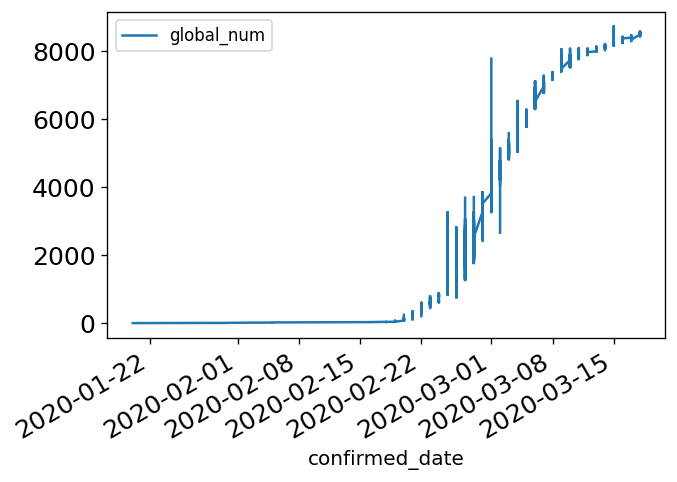

In [31]:
fig, ax = plt.subplots(dpi = 120)

df.plot(x = 'confirmed_date', y = 'global_num', ax = ax, fontsize = 15)

# Set font size of xlabel and ylabel
ax.xaxis.label.set_size(12)
ax.yaxis.label.set_size(15)

The general pattern is that `global_num` increases with `confirmed_date`.

**How many values of `global_num` are duplicated**?

In [32]:
df.global_num[df['global_num'].duplicated()].value_counts()

8476.0    1
1788.0    1
847.0     1
907.0     1
1675.0    1
7103.0    1
7982.0    1
8245.0    1
1753.0    1
2769.0    1
8062.0    1
Name: global_num, dtype: int64

Ok, the dupliacted values of `global_num` may have been wrongly included. But, we need to make sure that the entire rows are not duplicates.

In [33]:
df_g = df[['global_num']][df['global_num'].duplicated(keep=False)].dropna().sort_values(by=['global_num'])
print(f"number of records: {df_g.shape[0]}\n")
df.iloc[df_g.index]

number of records: 22



,patient_id,global_num,sex,age,country,province,city,disease,infection_case,infection_order,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,n_age,initial_sick_days
34,1000000035,847.0,male,30s,Korea,Seoul,etc,0,etc,2.285714,0.0,2020-02-19,2020-02-25,NaT,NaT,isolated,36.0,6.0
629,2000000041,847.0,male,30s,Korea,Gyeonggi-do,Gimpo-si,0,etc,2.285714,0.0,NaT,2020-02-25,NaT,NaT,isolated,36.0,NaN
632,2000000044,907.0,male,60s,Korea,Gyeonggi-do,Pyeongtaek-si,0,etc,2.285714,0.0,NaT,2020-02-25,NaT,NaT,isolated,67.0,NaN
37,1000000038,907.0,male,60s,Korea,Seoul,etc,0,etc,2.285714,0.0,2020-02-24,2020-02-25,NaT,NaT,isolated,67.0,1.0
652,2000000064,1675.0,female,70s,Korea,Gyeonggi-do,Goyang-si,0,etc,2.285714,0.0,NaT,2020-02-27,NaT,NaT,isolated,74.0,NaN
56,1000000057,1675.0,female,70s,Korea,Seoul,etc,0,Eunpyeong St. Mary's Hospital,2.285714,0.0,NaT,2020-02-27,NaT,NaT,released,74.0,NaN
646,2000000058,1753.0,female,30s,Korea,Gyeonggi-do,Yongin-si,0,contact with patient,2.285714,0.0,NaT,2020-02-27,NaT,NaT,isolated,30.0,NaN
1067,5000000004,1753.0,female,70s,Korea,Jeollabuk-do,etc,0,NaN,2.285714,0.0,NaT,2020-02-26,NaT,NaT,isolated,70.0,NaN
505,1500000010,1788.0,male,30s,Korea,Daejeon,Seo-gu,0,contact with patient,2.285714,4.0,NaT,2020-02-27,2020-03-11,NaT,released,NaN,NaN
60,1000000061,1788.0,male,60s,Korea,Seoul,Seodaemun-gu,0,Eunpyeong St. Mary's Hospital,2.285714,0.0,2020-02-26,2020-02-28,2020-03-14,NaT,released,65.0,2.0


The records are not really duplicates except the values of `global_num`. Each value of `global_num`s above is only appearing two times. We can check it below.

In [34]:
df_g[['global_num']].value_counts()

global_num
847.0         2
907.0         2
1675.0        2
1753.0        2
1788.0        2
2769.0        2
7103.0        2
7982.0        2
8062.0        2
8245.0        2
8476.0        2
dtype: int64

We will replace the second instance of `global_num` by increasing its value by `1` if that value is not there already in the data set. For instance, `index = 34` and `index = 629` have duplicates value of `global_num = 847`. The `confirmed_date` for both the records are same. So, we will change the second instance of the record (i.e., for `index = 629`) in our dataframe `df` by modifying its value of `global_num` to `847 + 1 = 848` if `848` is not there in the dataset. Before, we do it, let's only collect the second occurrences of the duplicate records of `global_num` and assign them again to the dataframe `df_g`. This can be done *without* passing the `keep` parameter in `duplicated()`. In this case, the default value of `keep = 'first'` will be considered, which means that all duplicates will be markedd as `True` except for the first occurrence. In our case, this means that the second occurence will be marked as `True`.

In [35]:
df_g = df[['global_num']][df['global_num'].duplicated()].dropna()
df_g

,global_num
278,8476.0
505,1788.0
629,847.0
632,907.0
652,1675.0
726,7103.0
777,7982.0
841,8245.0
1067,1753.0
1197,2769.0


Note, we can also extract the entire record of `df` using the `index` of `df_g` dataframe above.

In [36]:
df.loc[df_g.index]

,patient_id,global_num,sex,age,country,province,city,disease,infection_case,infection_order,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,n_age,initial_sick_days
278,1000000279,8476.0,male,90s,Korea,Seoul,Yongsan-gu,0,etc,2.285714,0.0,NaT,2020-03-18,NaT,NaT,isolated,91.0,NaN
505,1500000010,1788.0,male,30s,Korea,Daejeon,Seo-gu,0,contact with patient,2.285714,4.0,NaT,2020-02-27,2020-03-11,NaT,released,NaN,NaN
629,2000000041,847.0,male,30s,Korea,Gyeonggi-do,Gimpo-si,0,etc,2.285714,0.0,NaT,2020-02-25,NaT,NaT,isolated,36.0,NaN
632,2000000044,907.0,male,60s,Korea,Gyeonggi-do,Pyeongtaek-si,0,etc,2.285714,0.0,NaT,2020-02-25,NaT,NaT,isolated,67.0,NaN
652,2000000064,1675.0,female,70s,Korea,Gyeonggi-do,Goyang-si,0,etc,2.285714,0.0,NaT,2020-02-27,NaT,NaT,isolated,74.0,NaN
726,2000000138,7103.0,male,60s,Korea,Gyeonggi-do,Seongnam-si,0,etc,2.285714,0.0,NaT,2020-03-07,NaT,NaT,isolated,60.0,NaN
777,2000000189,7982.0,female,40s,Korea,Gyeonggi-do,Pyeongtaek-si,0,etc,2.285714,0.0,NaT,2020-03-13,NaT,NaT,isolated,46.0,NaN
841,2000000253,8245.0,male,NaN,Korea,Gyeonggi-do,Seongnam-si,0,contact with patient,2.285714,0.0,NaT,2020-03-16,NaT,NaT,NaN,21.0,NaN
1067,5000000004,1753.0,female,70s,Korea,Jeollabuk-do,etc,0,NaN,2.285714,0.0,NaT,2020-02-26,NaT,NaT,isolated,70.0,NaN
1197,6001000123,2769.0,female,80s,Korea,Gyeongsangbuk-do,Gyeongsan-si,0,NaN,2.285714,0.0,NaT,2020-02-28,NaT,NaT,isolated,85.0,NaN


Check if the next whole number after the duplicated `global_num` value is already contained or not in the dataset. If not, then increase the second instance (if both `confirmed_date`s are same) or the latest instance (as per `confirmed_date`) of the duplicated `global_num` value by `1`. Otherwise, do nothing.

In [37]:
def get_index(this_index,this_global_num):
    
    this_confirmed_date = df['confirmed_date'][this_index]

    both_confirmed_dates = df[['confirmed_date']][df['global_num'] == this_global_num] # double brackets [[..]] to form dataframe

    day0 = both_confirmed_dates.loc[both_confirmed_dates.index[0]]
    day0 = day0.values

    day1 = both_confirmed_dates.loc[both_confirmed_dates.index[1]]
    day1 = day1.values

    if day0 > day1:
        this_index = both_confirmed_dates.index[0]
    elif day0 <= day1:
        this_index = both_confirmed_dates.index[1]

    return this_index

def get_all_indices(increase_global_num_by):
    
    indices_to_update = []
    new_global_num = []
    for i in range(0,df_g.shape[0]):
    
        this_index = df_g.index[i]
        this_global_num = df_g['global_num'][this_index]
        df_empty = df[['global_num']][df.global_num == (this_global_num+increase_global_num_by)]
    
        if df_empty.empty == True:
            this_index = get_index(this_index,this_global_num)
            indices_to_update.append(this_index)
            new_global_num.append(this_global_num+increase_global_num_by)
        elif df_empty.empty != True:
            print(f"\n(index, 'global_num') = ({this_index}, {this_global_num}): The next value of 'global_num' exists")
            print(f"{df_empty}\n")

    print(f"indices_to_update: {indices_to_update}\n")
    print(f"new_global_num: {new_global_num}\n")
    
    return indices_to_update

In [38]:
increase_global_num_by = 1
indices_to_update = get_all_indices(increase_global_num_by)


(index, 'global_num') = (841, 8245.0): The next value of 'global_num' exists
     global_num
822      8246.0


(index, 'global_num') = (1593, 8062.0): The next value of 'global_num' exists
     global_num
215      8063.0

indices_to_update: [278, 60, 629, 632, 652, 726, 777, 646, 437]

new_global_num: [8477.0, 1789.0, 848.0, 908.0, 1676.0, 7104.0, 7983.0, 1754.0, 2770.0]



In [39]:
print('\nBefore updating')
df.loc[indices_to_update]


Before updating


,patient_id,global_num,sex,age,country,province,city,disease,infection_case,infection_order,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,n_age,initial_sick_days
278,1000000279,8476.0,male,90s,Korea,Seoul,Yongsan-gu,0,etc,2.285714,0.0,NaT,2020-03-18,NaT,NaT,isolated,91.0,NaN
60,1000000061,1788.0,male,60s,Korea,Seoul,Seodaemun-gu,0,Eunpyeong St. Mary's Hospital,2.285714,0.0,2020-02-26,2020-02-28,2020-03-14,NaT,released,65.0,2.0
629,2000000041,847.0,male,30s,Korea,Gyeonggi-do,Gimpo-si,0,etc,2.285714,0.0,NaT,2020-02-25,NaT,NaT,isolated,36.0,NaN
632,2000000044,907.0,male,60s,Korea,Gyeonggi-do,Pyeongtaek-si,0,etc,2.285714,0.0,NaT,2020-02-25,NaT,NaT,isolated,67.0,NaN
652,2000000064,1675.0,female,70s,Korea,Gyeonggi-do,Goyang-si,0,etc,2.285714,0.0,NaT,2020-02-27,NaT,NaT,isolated,74.0,NaN
726,2000000138,7103.0,male,60s,Korea,Gyeonggi-do,Seongnam-si,0,etc,2.285714,0.0,NaT,2020-03-07,NaT,NaT,isolated,60.0,NaN
777,2000000189,7982.0,female,40s,Korea,Gyeonggi-do,Pyeongtaek-si,0,etc,2.285714,0.0,NaT,2020-03-13,NaT,NaT,isolated,46.0,NaN
646,2000000058,1753.0,female,30s,Korea,Gyeonggi-do,Yongin-si,0,contact with patient,2.285714,0.0,NaT,2020-02-27,NaT,NaT,isolated,30.0,NaN
437,1200002769,2769.0,female,80s,Korea,Daegu,NaN,0,NaN,2.285714,0.0,NaT,2020-02-29,NaT,2020-03-02,deceased,86.0,NaN


Now, update the duplicated `global_num` as identified above by the indices in the variable `indices_to_update`.

In [40]:
df.loc[indices_to_update, 'global_num'] += increase_global_num_by
# df['global_num'][indices_to_update] += increase_global_num_by
print('\nAfter updating')
df.loc[indices_to_update]


After updating


,patient_id,global_num,sex,age,country,province,city,disease,infection_case,infection_order,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,n_age,initial_sick_days
278,1000000279,8477.0,male,90s,Korea,Seoul,Yongsan-gu,0,etc,2.285714,0.0,NaT,2020-03-18,NaT,NaT,isolated,91.0,NaN
60,1000000061,1789.0,male,60s,Korea,Seoul,Seodaemun-gu,0,Eunpyeong St. Mary's Hospital,2.285714,0.0,2020-02-26,2020-02-28,2020-03-14,NaT,released,65.0,2.0
629,2000000041,848.0,male,30s,Korea,Gyeonggi-do,Gimpo-si,0,etc,2.285714,0.0,NaT,2020-02-25,NaT,NaT,isolated,36.0,NaN
632,2000000044,908.0,male,60s,Korea,Gyeonggi-do,Pyeongtaek-si,0,etc,2.285714,0.0,NaT,2020-02-25,NaT,NaT,isolated,67.0,NaN
652,2000000064,1676.0,female,70s,Korea,Gyeonggi-do,Goyang-si,0,etc,2.285714,0.0,NaT,2020-02-27,NaT,NaT,isolated,74.0,NaN
726,2000000138,7104.0,male,60s,Korea,Gyeonggi-do,Seongnam-si,0,etc,2.285714,0.0,NaT,2020-03-07,NaT,NaT,isolated,60.0,NaN
777,2000000189,7983.0,female,40s,Korea,Gyeonggi-do,Pyeongtaek-si,0,etc,2.285714,0.0,NaT,2020-03-13,NaT,NaT,isolated,46.0,NaN
646,2000000058,1754.0,female,30s,Korea,Gyeonggi-do,Yongin-si,0,contact with patient,2.285714,0.0,NaT,2020-02-27,NaT,NaT,isolated,30.0,NaN
437,1200002769,2770.0,female,80s,Korea,Daegu,NaN,0,NaN,2.285714,0.0,NaT,2020-02-29,NaT,2020-03-02,deceased,86.0,NaN


We already know that two of the occurences (`index = 841` and `index = 1593`) have not been updated. Let's check again the duplicated values of `global_num` column.

In [41]:
df_g = df[['global_num']][df['global_num'].duplicated()].dropna()
df.loc[df_g.index]

,patient_id,global_num,sex,age,country,province,city,disease,infection_case,infection_order,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,n_age,initial_sick_days
841,2000000253,8245.0,male,NaN,Korea,Gyeonggi-do,Seongnam-si,0,contact with patient,2.285714,0.0,NaT,2020-03-16,NaT,NaT,NaN,21.0,NaN
1593,6001000519,8062.0,male,60s,Korea,Gyeongsangbuk-do,Gyeongsan-si,0,NaN,2.285714,0.0,NaT,2020-03-14,NaT,NaT,isolated,63.0,NaN


Let us now try if we can increase the second instance or the latest instance (depending on cases) of the duplicated `global_num` value by `2`. Otherwise, do nothing.

In [42]:
increase_global_num_by = 2
indices_to_update = get_all_indices(increase_global_num_by)


(index, 'global_num') = (841, 8245.0): The next value of 'global_num' exists
     global_num
839      8247.0

indices_to_update: [1593]

new_global_num: [8064.0]



In [43]:
print('\nBefore updating')
df.loc[indices_to_update]


Before updating


,patient_id,global_num,sex,age,country,province,city,disease,infection_case,infection_order,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,n_age,initial_sick_days
1593,6001000519,8062.0,male,60s,Korea,Gyeongsangbuk-do,Gyeongsan-si,0,NaN,2.285714,0.0,NaT,2020-03-14,NaT,NaT,isolated,63.0,NaN


In [44]:
df.loc[indices_to_update, 'global_num'] += increase_global_num_by
# df['global_num'][indices_to_update] += increase_global_num_by
print('\nAfter updating')
df.loc[indices_to_update]


After updating


,patient_id,global_num,sex,age,country,province,city,disease,infection_case,infection_order,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,n_age,initial_sick_days
1593,6001000519,8064.0,male,60s,Korea,Gyeongsangbuk-do,Gyeongsan-si,0,NaN,2.285714,0.0,NaT,2020-03-14,NaT,NaT,isolated,63.0,NaN


We see that one of the occurences (`index = 841`) has not yet been updated. Let's check again the duplicated values.

In [45]:
df_g = df[['global_num']][df['global_num'].duplicated()].dropna()
df.loc[df_g.index]

,patient_id,global_num,sex,age,country,province,city,disease,infection_case,infection_order,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,n_age,initial_sick_days
841,2000000253,8245.0,male,NaN,Korea,Gyeonggi-do,Seongnam-si,0,contact with patient,2.285714,0.0,NaT,2020-03-16,NaT,NaT,NaN,21.0,NaN


We will now try to increase its `global_num` vaule by `3` if this value does not already exist in the dataset.

In [46]:
increase_global_num_by = 3
indices_to_update = get_all_indices(increase_global_num_by)

indices_to_update: [841]

new_global_num: [8248.0]



Ok, yes, we now update this value of `8245` to `8245 + 3 = 8248` since our dataset `df` does not have a value of `8048` in the `global_num` column.

In [47]:
print('\nBefore updating')
df.loc[indices_to_update]


Before updating


,patient_id,global_num,sex,age,country,province,city,disease,infection_case,infection_order,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,n_age,initial_sick_days
841,2000000253,8245.0,male,NaN,Korea,Gyeonggi-do,Seongnam-si,0,contact with patient,2.285714,0.0,NaT,2020-03-16,NaT,NaT,NaN,21.0,NaN


In [48]:
df.loc[indices_to_update, 'global_num'] += increase_global_num_by
# df['global_num'][indices_to_update] += increase_global_num_by
print('\nAfter updating')
df.loc[indices_to_update]


After updating


,patient_id,global_num,sex,age,country,province,city,disease,infection_case,infection_order,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,n_age,initial_sick_days
841,2000000253,8248.0,male,NaN,Korea,Gyeonggi-do,Seongnam-si,0,contact with patient,2.285714,0.0,NaT,2020-03-16,NaT,NaT,NaN,21.0,NaN


In [49]:
df_g = df[['global_num']][df['global_num'].duplicated(keep=False)].dropna().sort_values(by=['global_num'])
print(f"number of records: {df_g.shape[0]}\n")
df.iloc[df_g.index]

number of records: 0



,patient_id,global_num,sex,age,country,province,city,disease,infection_case,infection_order,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state,n_age,initial_sick_days


**<font color='magenta'>Ok, all duplicated values have been taken care of for the `global_num` column.</font>**

**<font color='blue'>Let's focus on the missing values of `global_num`.</font>**

In [50]:
print(f"There are {df.global_num.isnull().sum()} missing values in 'global_num'.")

There are 904 missing values in 'global_num'.


... and for `confirmed_date` column:

In [51]:
print(f"There are {df.confirmed_date.isnull().sum()} missing values in 'confirmed_date'.")

There are 141 missing values in 'confirmed_date'.


**Why not filling up the missing values by mean/median/mode etc.?**

We have seen earlier in the plot that `global_num` typically increases with `confirmed_date`. So, it does not make sense to fill up the missing values of `global_num` with their mean/median/mode values. We will need to consider each day of the 2-month period (see the code block below) for which our data is available and explore the `global_num` values and fill the missing values appropriately for each day.

In [52]:
min(pd.concat([df.symptom_onset_date, df.confirmed_date, df.released_date, df.deceased_date], axis = 0)), max(pd.concat([df.symptom_onset_date, df.confirmed_date, df.released_date, df.deceased_date], axis = 0))

(Timestamp('2020-01-19 00:00:00'), Timestamp('2020-03-19 00:00:00'))

Note that the maximum value of `global_num` in our data set is 8717 while we have 2218 samples in our dataset. This means that there will be lot of whole nunbers between the minimum value of `global_num` and maximum value of `global_num`. We will use these numbers that are not available in this set to fill up the missing values. We will only consider a subset of these whole numbers in the same range that is consistent with each day.

In [53]:
df.shape[0]

2218

In [54]:
(df.global_num.min(), df.global_num.max())

(1.0, 8717.0)

**How to fill up the missing values of `global_num`?**

To fill up the missing values of `global_num`, we will follow the following steps:

+ Collect the records/rows of non-missing values of `confirmed_date` and the corresponding values of `global_num` in a dataframe `df1`.

+ Sort the dataframe first by `confirmed_date`, then by `index` of each record, finally by `global_num`. Re-assign this sorted dataframe to `df1`.

+ Then, run a `for loop` over the unique values of the `confirmed_date`. For each day, do the following:
    - Find out the minimum value of `global_num` and assign this value to a variable `min_value_this_day`.
    - Gather the indices for which `global_num` values are missing.
    - For each record or row associated with those indices, replace the missing value of `global_num` by a value given by `min_value_this_day + 1` if this value does not exist in the dataset. If `min_value_this_day + 1` already exists, then increase `min_value_this_day` by `1`, and try it again until successful. Do this step in a `while loop`.

Let's find out how many values of `confirmed_date` are there in the dataset.

In [55]:
print(f"\nThere are {len(df.confirmed_date.unique())} days of 'confirmed_date' in our data set.\n")
df.confirmed_date.unique()


There are 46 days of 'confirmed_date' in our data set.



array(['2020-01-23T00:00:00.000000000', '2020-01-30T00:00:00.000000000',
       '2020-01-31T00:00:00.000000000', '2020-02-02T00:00:00.000000000',
       '2020-02-05T00:00:00.000000000', '2020-02-06T00:00:00.000000000',
       '2020-02-07T00:00:00.000000000', '2020-02-16T00:00:00.000000000',
       '2020-02-19T00:00:00.000000000', '2020-02-20T00:00:00.000000000',
       '2020-02-21T00:00:00.000000000', '2020-02-22T00:00:00.000000000',
       '2020-02-23T00:00:00.000000000', '2020-02-26T00:00:00.000000000',
       '2020-02-24T00:00:00.000000000', '2020-02-25T00:00:00.000000000',
       '2020-02-27T00:00:00.000000000', '2020-02-28T00:00:00.000000000',
       '2020-02-29T00:00:00.000000000', '2020-03-01T00:00:00.000000000',
       '2020-03-02T00:00:00.000000000', '2020-03-04T00:00:00.000000000',
       '2020-03-05T00:00:00.000000000', '2020-03-06T00:00:00.000000000',
       '2020-03-07T00:00:00.000000000', '2020-03-08T00:00:00.000000000',
       '2020-03-09T00:00:00.000000000', '2020-03-10

The value of `'NaT'` represents that there are some misssing values of `confirmed_date`, and we know that there 141 missing values. Let's only focus on the non-missing values of `confirmed_date` and corresponding missing values (if any) of `global_num`.

In [56]:
# Collect the records/rows of non-missing values of 'confirmed_date' and corresponding values of 'global_num'
df1 = df[['global_num','confirmed_date']][df.confirmed_date.notna()]

# Sort them by 'confirmed_date', then 'index' of each record, finally by 'global_num'
df1 = df1.rename_axis('missingIdx').sort_values(by=['confirmed_date', 'missingIdx', 'global_num'])

# Let's create an array of all the individual dates in 'df1' over which we will run a 'for loop'
# to fill up the missing values of 'global_num' (if any)
unique_confirmed_date = df1.confirmed_date.unique()

In [57]:
# Let's check for a few dates to see how the 'df1' looks
def explore_global_num(this_day, print_results = 1):
    """
    Input parameter
    ----------
    this_day      : day in datetime format
            a day in 'unique_confirmed_date'

    Returns
    -------
    Returna and prints a pandas' dataframe 
    """
    if print_results == 1:
        print(f"\nFor confirmed_date: {this_day}\n")
        print(f"\tThere are {df1['global_num'][df1.confirmed_date == this_day].isnull().sum()} missing values of 'global_num'.\n")
        
    df1_day = df1[df1.confirmed_date == this_day]
    
    return df1_day

Consider a day at the end of the 2-month period.

In [58]:
# Call the function
this_day = unique_confirmed_date[-1]
df1_day = explore_global_num(this_day)
df1_day


For confirmed_date: 2020-03-18T00:00:00.000000000

	There are 4 missing values of 'global_num'.



,global_num,confirmed_date
missingIdx,,
271,8517.0,2020-03-18
272,8508.0,2020-03-18
273,8529.0,2020-03-18
274,8485.0,2020-03-18
275,8461.0,2020-03-18
276,8446.0,2020-03-18
277,8476.0,2020-03-18
278,8477.0,2020-03-18
279,8547.0,2020-03-18


The 4 missing values of `global_num` should be replaced by the values in the same ranges as shown above for the day of `2020-03-18`.

Let's check another date at the beginning of the 2-month period.

In [59]:
# Call the function
this_day = unique_confirmed_date[9]
df1_day = explore_global_num(this_day)
df1_day


For confirmed_date: 2020-02-05T00:00:00.000000000

	There are 0 missing values of 'global_num'.



,global_num,confirmed_date
missingIdx,,
8,19.0,2020-02-05
9,21.0,2020-02-05
447,18.0,2020-02-05
594,17.0,2020-02-05
595,20.0,2020-02-05


Let's now fill up missing values by running a `for loop` over the array of days `unique_confirmed_date` by considering each day. As explained earlier, we will use the values of `global_num` in the same range of values for each day while filling the missing values for that day.

In [60]:
for this_day in unique_confirmed_date:
    
    df1_day = explore_global_num(this_day, print_results = 0)
    
    all_global_numbers_this_day = df1_day.global_num
    
    n_missing_values_this_day = all_global_numbers_this_day.isnull().sum()
    
    if n_missing_values_this_day > 0:
        min_value_this_day = all_global_numbers_this_day.min()
        # max_value = all_global_numbers_this_day.max()
        
        index_missing_global_num = df1_day[df1_day.global_num.isnull()].index
        for this_index in index_missing_global_num:
            
            df_empty = df[['global_num']][df.global_num == min_value_this_day+1]
            while df_empty.empty != True:
                min_value_this_day += 1
                df_empty = df[['global_num']][df.global_num == min_value_this_day+1]
            else:
                if df_empty.empty == True:
                    df.loc[this_index,'global_num'] = min_value_this_day+1
                    min_value_this_day += 1

In [61]:
# Check how it fills up the holes for one of the days
this_day = unique_confirmed_date[-1]
df1_day = explore_global_num(this_day)
index_missing_global_num = df1_day[df1_day.global_num.isnull()].index

print(f"Before filling")
print(df1.loc[index_missing_global_num,['global_num', 'confirmed_date']])

print(f"\nAfter filling")
print(df.loc[index_missing_global_num,['global_num', 'confirmed_date']])


For confirmed_date: 2020-03-18T00:00:00.000000000

	There are 4 missing values of 'global_num'.

Before filling
            global_num confirmed_date
missingIdx                           
868                NaN     2020-03-18
869                NaN     2020-03-18
887                NaN     2020-03-18
888                NaN     2020-03-18

After filling
            global_num confirmed_date
missingIdx                           
868             8428.0     2020-03-18
869             8429.0     2020-03-18
887             8430.0     2020-03-18
888             8431.0     2020-03-18


In [62]:
(df.global_num.min(), df.global_num.max())

(1.0, 8717.0)

In [63]:
print(f"Now... there are {df.global_num.isnull().sum()} missing values in 'global_num'.")

Now... there are 141 missing values in 'global_num'.


**The number of missing values for both the columns `global_num` and `confirmed_date` are same now**.

Let's check if the missing values are for the same set of records.

In [64]:
set(df[df.global_num.isnull()].index) - set(df[df.confirmed_date.isnull()].index)

set()

**Yes, 141 missing values of `global_num` and `confirmed_date` are for the same set of records.**

Before moving forward, let's check the if there are any duplicated values, which we should not have. But, let's ensure it.

In [65]:
df.global_num[df['global_num'].duplicated()].value_counts()

Series([], Name: global_num, dtype: int64)

**Great! No duplicated values exist.**

Next question is: *How do we replace the remaining missing values of `global_num`?* Let's see if we have any other datetime features available for the missing values of `global_num`.

In [66]:
df[['global_num', 'symptom_onset_date', 'released_date', 'deceased_date']][df.global_num.isnull()]

,global_num,symptom_onset_date,released_date,deceased_date
1726,NaN,NaT,NaT,NaT
1727,NaN,NaT,NaT,NaT
1728,NaN,NaT,NaT,NaT
1729,NaN,NaT,NaT,NaT
1730,NaN,NaT,NaT,NaT
...,...,...,...,...
1944,NaN,NaT,NaT,NaT
1945,NaN,NaT,NaT,NaT
1946,NaN,NaT,NaT,NaT
1947,NaN,NaT,NaT,NaT


In [67]:
set(df[df.global_num.isnull()].index) - set(df[df.symptom_onset_date.isnull()].index)

set()

In [68]:
set(df[df.global_num.isnull()].index) - set(df[df.released_date.isnull()].index)

set()

In [69]:
set(df[df.global_num.isnull()].index) - set(df[df.deceased_date.isnull()].index)

set()

All the datetime features in our data has missing values corresponding to records for which we have 141 missing `global_num` features. **We will drop these rows**.

But, we will not do it right now. There are other columns with existing values in these rows and those values may be useful. We will see what happens until we clean and fill missing values of all the other columns.

### Feature `initial_sick_days`

In [70]:
df.initial_sick_days.value_counts(dropna=False).sort_index(ascending=True)

-28.0       2
-26.0       1
-24.0       2
-23.0       3
-22.0       1
-21.0       2
-20.0       2
-19.0       2
-18.0       3
-14.0       3
-6.0        1
-2.0        1
-1.0        1
 0.0        8
 1.0       35
 2.0       28
 3.0       29
 4.0       18
 5.0       19
 6.0        9
 7.0        6
 8.0        8
 9.0        2
 10.0       3
 11.0       1
 12.0       2
 15.0       1
 NaN     2025
Name: initial_sick_days, dtype: int64

The negative values of `initial_sick_days` indicates that those patients' symptom did not show up before their COVID test results were confirmed. In this case, `confirmed_date` was before `symptom_onset_date`. **They are possibly asymptomatic patients**.

**<font color='blue'>Let us fill its missing values by its mode.</font>**

In [71]:
df.initial_sick_days.fillna(df.initial_sick_days.mode()[0], inplace = True)
df.initial_sick_days.value_counts(dropna=False)

 1.0     2060
 3.0       29
 2.0       28
 5.0       19
 4.0       18
 6.0        9
 0.0        8
 8.0        8
 7.0        6
 10.0       3
-14.0       3
-23.0       3
-18.0       3
-28.0       2
 9.0        2
-21.0       2
-19.0       2
-20.0       2
-24.0       2
 12.0       2
-2.0        1
-6.0        1
-1.0        1
 11.0       1
-26.0       1
 15.0       1
-22.0       1
Name: initial_sick_days, dtype: int64

### All the Date Features

**<font color='blue'>Remove date columns from the data.</font>**

In [72]:
df = df.drop(['symptom_onset_date','confirmed_date','released_date','deceased_date'],axis =1)

Check for any remaining null values.

In [73]:
count_null_values(df)

,VarName,NullCount
0,infection_case,1055
1,n_age,455
2,age,261
3,sex,145
4,global_num,141
5,state,88
6,city,65


### Features `age` and `n_age`

In [74]:
df[['age']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2218 entries, 0 to 2217
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   age     1957 non-null   object
dtypes: object(1)
memory usage: 17.5+ KB


In [75]:
age_keys = list(df.age.value_counts().index)
age_keys

['20s', '50s', '40s', '30s', '60s', '70s', '80s', '10s', '0s', '90s', '100s']

Remove the 's' from the end and convert the datatype from `object` to `int` for the `age` column.

In [76]:
age_values = [x[:-1] for x in age_keys]
age_values = [int(i) for i in age_values]
age_values

[20, 50, 40, 30, 60, 70, 80, 10, 0, 90, 100]

In [77]:
# using zip() to create a dictionary to use in `.replace` function
age_dict = dict(zip(age_keys, age_values))
age_dict

{'20s': 20,
 '50s': 50,
 '40s': 40,
 '30s': 30,
 '60s': 60,
 '70s': 70,
 '80s': 80,
 '10s': 10,
 '0s': 0,
 '90s': 90,
 '100s': 100}

In [78]:
df["age"].replace(age_dict, inplace=True)
df["age"] = df["age"].astype('Int64')
df[['age']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2218 entries, 0 to 2217
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   age     1957 non-null   Int64
dtypes: Int64(1)
memory usage: 19.6 KB


In [79]:
df[['n_age']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2218 entries, 0 to 2217
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   n_age   1763 non-null   float64
dtypes: float64(1)
memory usage: 17.5 KB


**<u>Note</u>**: We see that the `age` column has 1957 entries while the newly created `n_age` column has 1763 entries. We need to get some of the missing values of `n_age` from `age` column.

Replace the missing values of `n_age` by the available values of the `age` column.

In [80]:
index_missing_nage = df[['age', 'n_age']].loc[df.n_age.isnull()].index
df[['age', 'n_age']].iloc[index_missing_nage]

,age,n_age
446,40,NaN
447,20,NaN
448,30,NaN
449,30,NaN
450,30,NaN
...,...,...
2128,0,NaN
2136,70,NaN
2159,<NA>,NaN
2160,<NA>,NaN


In [81]:
df.n_age.fillna(df.age, inplace=True)
df[['age', 'n_age']].iloc[index_missing_nage]

,age,n_age
446,40,40.0
447,20,20.0
448,30,30.0
449,30,30.0
450,30,30.0
...,...,...
2128,0,0.0
2136,70,70.0
2159,<NA>,<NA>
2160,<NA>,<NA>


In [82]:
df[['age', 'n_age']].isnull().sum()

age      261
n_age    151
dtype: int64

**We can now drop the `age` column**.

In [83]:
df.drop(['age'], axis=1, inplace=True)

Fill null values of `n_age` column by its mean.

In [84]:
df['n_age'] = df['n_age'].fillna(df['n_age'].mean())

In [85]:
df.n_age.isnull().sum()

0

### Feature `sex`

In [86]:
df[['sex']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2218 entries, 0 to 2217
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   sex     2073 non-null   object
dtypes: object(1)
memory usage: 17.5+ KB


In [87]:
df.sex.value_counts(dropna = False)

female    1171
male       902
NaN        145
Name: sex, dtype: int64

Since there are more females than males, we will assign `male` to the patients with missing gender to have a balanced feature of `sex` column.

In [88]:
df.sex = df.sex.fillna('male')

In [89]:
df.sex.isnull().sum()

0

### Feature `city`

In [90]:
df[['city']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2218 entries, 0 to 2217
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   city    2153 non-null   object
dtypes: object(1)
memory usage: 17.5+ KB


Note that there is no missing values for `province`.

In [91]:
df.province.isnull().sum()

0

Replace the missing values of `city` by the corresponding values of the `province` column.

In [92]:
df.city.fillna(df.province, inplace=True)

In [93]:
df.city.isnull().sum()

0

### Feature `infection_case`

In [94]:
df[['infection_case']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2218 entries, 0 to 2217
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   infection_case  1163 non-null   object
dtypes: object(1)
memory usage: 17.5+ KB


In [95]:
df.infection_case.value_counts(dropna = False)

NaN                                 1055
contact with patient                 530
etc                                  220
Guro-gu Call Center                  102
Shincheonji Church                    86
overseas inflow                       61
Onchun Church                         33
gym facility in Cheonan               30
Ministry of Oceans and Fisheries      27
Cheongdo Daenam Hospital              21
Dongan Church                         17
Eunpyeong St. Mary's Hospital         14
Seongdong-gu APT                      13
gym facility in Sejong                 4
Suyeong-gu Kindergarten                3
River of Grace Community Church        1
Pilgrimage to Israel                   1
Name: infection_case, dtype: int64

In [96]:
df.infection_case.mode()

0    contact with patient
dtype: object

We will use `mode` value to impute the `infection_case` column.

In [97]:
df.infection_case = df.infection_case.fillna('contact with patient')

In [98]:
df.infection_case.isnull().sum()

0

In [99]:
df.infection_case.value_counts(dropna = False)

contact with patient                1585
etc                                  220
Guro-gu Call Center                  102
Shincheonji Church                    86
overseas inflow                       61
Onchun Church                         33
gym facility in Cheonan               30
Ministry of Oceans and Fisheries      27
Cheongdo Daenam Hospital              21
Dongan Church                         17
Eunpyeong St. Mary's Hospital         14
Seongdong-gu APT                      13
gym facility in Sejong                 4
Suyeong-gu Kindergarten                3
River of Grace Community Church        1
Pilgrimage to Israel                   1
Name: infection_case, dtype: int64

### Feature `state`

**<font color='blue'>Replace null values in the `state` column with `missing`.</font>**

In [100]:
df.state = df.state.fillna('missing')

In [101]:
df.state.value_counts(dropna=False)

isolated    1791
released     307
missing       88
deceased      32
Name: state, dtype: int64

**<font color='red'>As mentioned earlier, we have an imbalanced data set.</font>**

**<font color='blue'> Check for any remaining null values.</font>**

In [102]:
count_null_values(df)

,VarName,NullCount
0,global_num,141


**<font color='blue'>Let's drop all the records for which `global_num` is `NaN`.</font>**

Actually, [don't drop](https://stackoverflow.com/questions/13413590/how-to-drop-rows-of-pandas-dataframe-whose-value-in-a-certain-column-is-nan#:~:text=Don%27t%20drop%2C-,just%20take%20the%20rows,-where%20EPS%20is), just take the rows where `global_num` is not `NaN`.

In [103]:
df = df[df.global_num.notna()]

In [104]:
df.state.value_counts(dropna=False)

isolated    1651
released     307
missing       88
deceased      31
Name: state, dtype: int64

We see that all the rows of missing values of `global_num` were associated with `state = 'isolated'` except one which was associated with the `state = 'deceased'`.

In [105]:
count_null_values(df)

,VarName,NullCount


In [106]:
df.head()

,patient_id,global_num,sex,country,province,city,disease,infection_case,infection_order,contact_number,state,n_age,initial_sick_days
0,1000000001,2.0,male,Korea,Seoul,Gangseo-gu,0,overseas inflow,1.0,75.0,released,56.0,1.0
1,1000000002,5.0,male,Korea,Seoul,Jungnang-gu,0,overseas inflow,1.0,31.0,released,33.0,1.0
2,1000000003,6.0,male,Korea,Seoul,Jongno-gu,0,contact with patient,2.0,17.0,released,56.0,1.0
3,1000000004,7.0,male,Korea,Seoul,Mapo-gu,0,overseas inflow,1.0,9.0,released,29.0,4.0
4,1000000005,9.0,female,Korea,Seoul,Seongbuk-gu,0,contact with patient,2.0,2.0,released,28.0,1.0


In [107]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2077 entries, 0 to 2217
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   patient_id         2077 non-null   int64  
 1   global_num         2077 non-null   float64
 2   sex                2077 non-null   object 
 3   country            2077 non-null   object 
 4   province           2077 non-null   object 
 5   city               2077 non-null   object 
 6   disease            2077 non-null   int64  
 7   infection_case     2077 non-null   object 
 8   infection_order    2077 non-null   float64
 9   contact_number     2077 non-null   float64
 10  state              2077 non-null   object 
 11  n_age              2077 non-null   Float64
 12  initial_sick_days  2077 non-null   float64
dtypes: Float64(1), float64(4), int64(2), object(6)
memory usage: 229.2+ KB


Review the count of unique values by column.

In [108]:
print(df.nunique())

patient_id           2077
global_num           2077
sex                     2
country                 4
province               17
city                  135
disease                 2
infection_case         16
infection_order         7
contact_number         72
state                   4
n_age                  97
initial_sick_days      27
dtype: int64


Review the percent of unique values by column.

In [109]:
print(df.nunique()/df.shape[0])

patient_id           1.000000
global_num           1.000000
sex                  0.000963
country              0.001926
province             0.008185
city                 0.064998
disease              0.000963
infection_case       0.007703
infection_order      0.003370
contact_number       0.034665
state                0.001926
n_age                0.046702
initial_sick_days    0.013000
dtype: float64


Review the range of values per column.

In [110]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
patient_id,2077.0,3.879120e+09,2.200900e+09,1.000000e+09,1.600000e+09,4.100000e+09,6.001000e+09,7.000000e+09
global_num,2077.0,4.164744e+03,2.901079e+03,1.000000e+00,1.249000e+03,4.199000e+03,7.153000e+03,8.717000e+03
disease,2077.0,9.147809e-03,9.522864e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
infection_order,2077.0,2.285852e+00,1.762510e-01,1.000000e+00,2.285714e+00,2.285714e+00,2.285714e+00,6.000000e+00
contact_number,2077.0,4.774675e+00,4.160612e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.160000e+03
n_age,2077.0,4.419174e+01,1.939087e+01,0.000000e+00,2.700000e+01,4.420416e+01,5.800000e+01,1.040000e+02
initial_sick_days,2077.0,9.826673e-01,2.477974e+00,-2.800000e+01,1.000000e+00,1.000000e+00,1.000000e+00,1.500000e+01


In [111]:
df.describe(include=[object]).T

,count,unique,top,freq
sex,2077,2,female,1171
country,2077,4,Korea,2065
province,2077,17,Gyeongsangbuk-do,914
city,2077,135,Gyeongsan-si,535
infection_case,2077,16,contact with patient,1444
state,2077,4,isolated,1651


### Check for duplicated rows

In [112]:
duplicateRowsDF = df[df.duplicated()]
duplicateRowsDF

,patient_id,global_num,sex,country,province,city,disease,infection_case,infection_order,contact_number,state,n_age,initial_sick_days


Print the categorical columns and their associated levels.

In [113]:
dfo = df.select_dtypes(include=['object'], exclude=['datetime'])
print(f"dfo.shape: {dfo.shape}")

#get levels for all variables
vn = pd.DataFrame(dfo.nunique()).reset_index()
vn.columns = ['VarName', 'LevelsCount']
vn.sort_values(by='LevelsCount', ascending =False)
vn

dfo.shape: (2077, 6)


,VarName,LevelsCount
0,sex,2
1,country,4
2,province,17
3,city,135
4,infection_case,16
5,state,4


# Exploratory Data Analysis

**<font color='blue'> Plot the correlation heat map for the features.</font>**

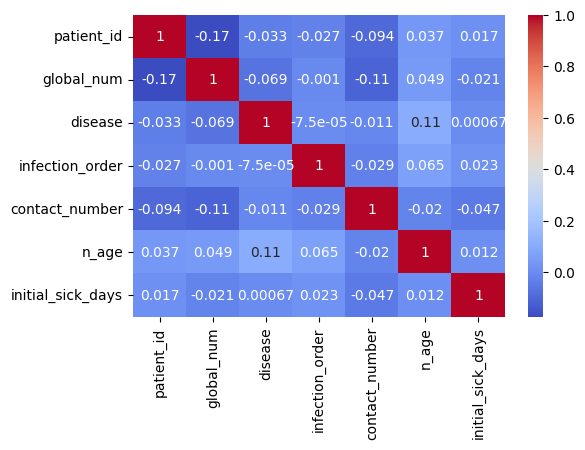

In [114]:
# Make a heatmap of the data
plt.figure(dpi = 100)

ax = sns.heatmap(df.corr(), cmap="coolwarm", annot=True, annot_kws={"fontsize": 10})

ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 10, rotation=90);
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 10);

ax.collections[0].colorbar.ax.tick_params(labelsize=10)

We see that the **numerical features are only weakly correlated** to each other. So, we need to consider all these features as input variables for our Random Forest Classifier.

**<font color='blue'> Plot the boxplots to check for outliers. </font>**

In [115]:
df1 = df.select_dtypes(include=['int','float'])
df1_list = list(df1.columns.values)
df1_list

['patient_id',
 'global_num',
 'disease',
 'infection_order',
 'contact_number',
 'n_age',
 'initial_sick_days']

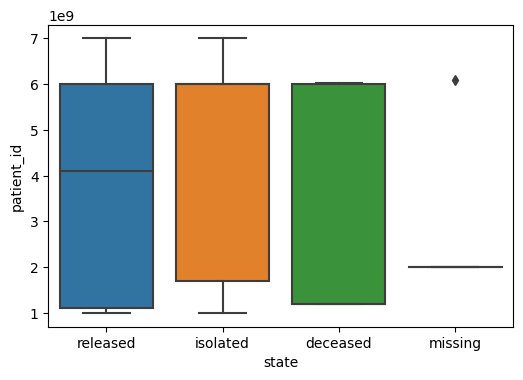

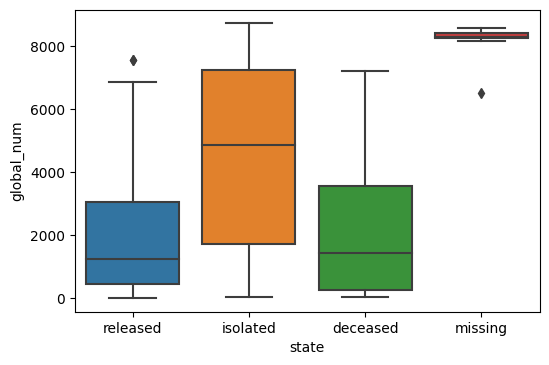

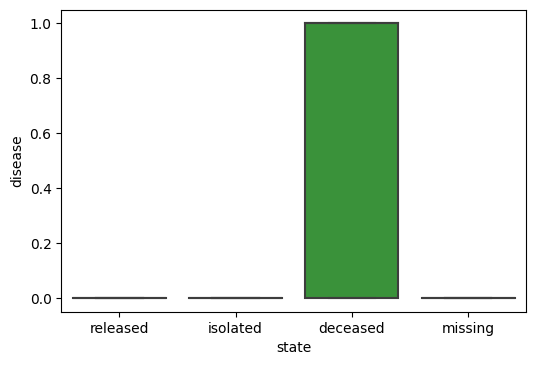

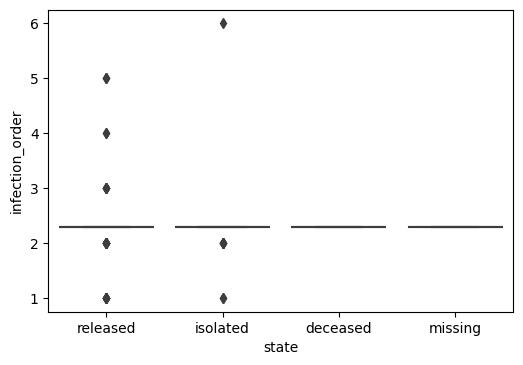

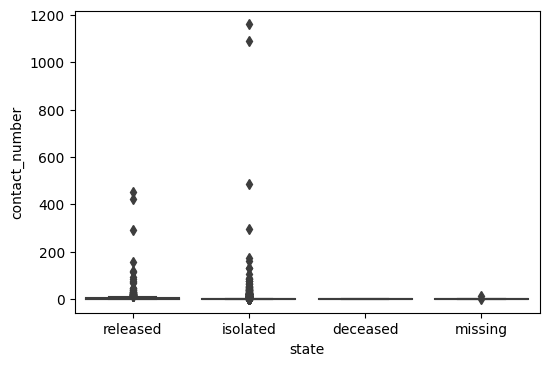

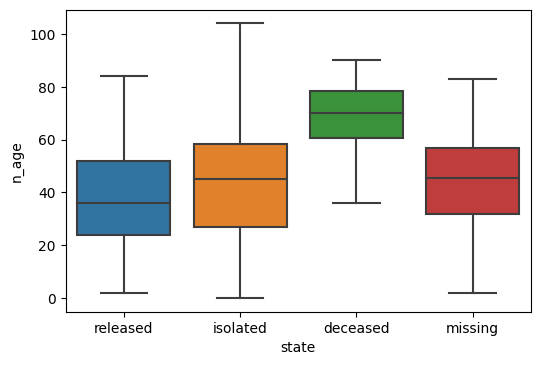

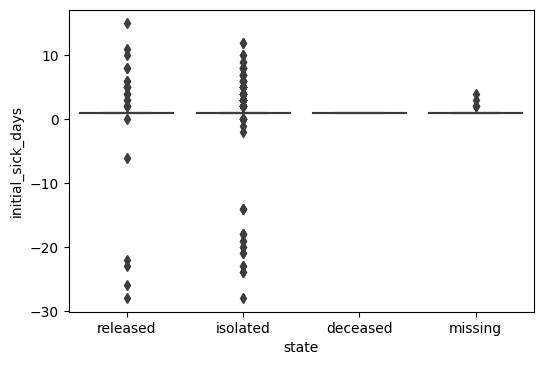

In [116]:
for feature in df1_list:
    plt.figure(dpi = 100)
    sns.boxplot(x='state', y=feature, data=df);

Let's count the number of outliers of each numerical columns. See this [stackoverflow response](https://stackoverflow.com/questions/39068214/how-to-count-outliers-for-all-columns-in-python).

In [117]:
Q1 = df1.quantile(0.25)
Q3 = df1.quantile(0.75)
IQR = Q3 - Q1

In [118]:
print(f"\nNumber of outliers:")
((df1 < (Q1 - 1.5 * IQR)) | (df1 > (Q3 + 1.5 * IQR))).sum()


Number of outliers:


patient_id             0
global_num             0
disease               19
infection_order       41
contact_number       364
n_age                  0
initial_sick_days    158
dtype: int64

# Preprocessing and Training Data Development

**<font color='blue'> Create dummy features for object type features. </font>**

**Note**: A random forest classifier is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting (re: [sklearn.ensemble.RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#:~:text=A%20random%20forest%20is%20a%20meta%20estimator%20that%20fits%20a%20number%20of%20decision%20tree%20classifiers)). 

Decision tree classifier can handle both numerical and categorical data. However, the `scikit-learn` implementation does not support categorical variables for now (re:[Decision Trees](https://scikit-learn.org/stable/modules/tree.html#:~:text=data.%20However%2C%20the-,scikit%2Dlearn%20implementation%20does%20not%20support%20categorical%20variables%20for%20now,-.%20Other%20techniques%20are)). Therefore, we will convert our categorical variables into dummy/indicator variables (re: [pandas.get_dummies](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html)) using one-hot-encoding.

In [119]:
X = pd.get_dummies(df.drop('state', axis=1))
print(f"X.shape: {X.shape}")
X.head()

X.shape: (2077, 181)


,patient_id,global_num,disease,infection_order,contact_number,n_age,initial_sick_days,sex_female,sex_male,country_China,...,infection_case_Pilgrimage to Israel,infection_case_River of Grace Community Church,infection_case_Seongdong-gu APT,infection_case_Shincheonji Church,infection_case_Suyeong-gu Kindergarten,infection_case_contact with patient,infection_case_etc,infection_case_gym facility in Cheonan,infection_case_gym facility in Sejong,infection_case_overseas inflow
0,1000000001,2.0,0,1.0,75.0,56.0,1.0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,1000000002,5.0,0,1.0,31.0,33.0,1.0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,1000000003,6.0,0,2.0,17.0,56.0,1.0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,1000000004,7.0,0,1.0,9.0,29.0,4.0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
4,1000000005,9.0,0,2.0,2.0,28.0,1.0,1,0,0,...,0,0,0,0,0,1,0,0,0,0


In [120]:
y = df['state']
print(f"\ny.shape: {y.shape}\n")
y.value_counts()


y.shape: (2077,)



isolated    1651
released     307
missing       88
deceased      31
Name: state, dtype: int64

### Split the data into test and train subsamples

Make sure you also pass `stratify = y` to split the data in a stratified fashion.

In [121]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1, stratify = y)

### Scaling of Data

The random forest classification algorithm is based on multiple decision tree classifiers, and the decision tree classifier requires little data preparation (re: [Decision Trees](https://scikit-learn.org/stable/modules/tree.html#:~:text=Requires%20little%20data%20preparation)). The decision tree classifier uses partitioning, i.e., a set of if-then-else decision rules; see [Decision Trees](https://scikit-learn.org/stable/modules/tree.html#:~:text=a%20set%20of%20if%2Dthen%2Delse%20decision%20rules). Even if you apply feature scaling, the result would still be the same. Hence, we will **not apply any scaling on our data**.

**Side Note**: Note that the feature scaling slightly affects the results of the random forest regressors (see this [article](https://towardsdatascience.com/how-data-normalization-affects-your-random-forest-algorithm-fbc6753b4ddf)). But, the results are practically same.

In [122]:
#scale data
# from sklearn import preprocessing
# import numpy as np
# # build scaler based on training data and apply it to test data to then also scale the test data
# scaler = preprocessing.StandardScaler().fit(X_train)
# X_train_scaled=scaler.transform(X_train)
# X_test_scaled=scaler.transform(X_test)

# Modeling

### Random Forest Classifier and Hyperparameter optimization

Pass `class_weight='balanced'` because we have imbalance data set.

In [123]:
# Classifier
clf = RandomForestClassifier(random_state=42, class_weight='balanced')

# GridSearchCV to tune number of trees
params = {'n_estimators': [10, 50, 100, 200, 300]}
rf_grid_cv = GridSearchCV(clf, params)
rf_grid_cv.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             param_grid={'n_estimators': [10, 50, 100, 200, 300]})

In [124]:
# Print best parameters and results

print(rf_grid_cv.best_params_)
print(rf_grid_cv.best_score_)

{'n_estimators': 50}
0.8518940627374363


In [125]:
# Train score
y_train_pred = rf_grid_cv.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Train set accuracy: {train_accuracy}")

Train set accuracy: 1.0


In [126]:
# Test score
y_test_pred = rf_grid_cv.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test set accuracy: {test_accuracy}")

Test set accuracy: 0.8653846153846154


The fit model shows an overall test accuracy of 86.5%. This is great and indicates our model was effectively able to identify the status of a patients in the South Korea dataset. But, training accuraccy 100% means that this model is also overfitting.

### Create Confusion Matrix Plots
Confusion matrices are great ways to review your model performance for a multi-class classification problem. Being able to identify which class the misclassified observations end up in is a great way to determine if you need to build additional features to improve your overall model. In the example below we plot a regular counts confusion matrix as well as a weighted percent confusion matrix. The percent confusion matrix is particulary helpful when you have unbalanced class sizes.

In [127]:
y_train.value_counts(dropna = False).sort_index()

deceased      25
isolated    1320
missing       70
released     246
Name: state, dtype: int64

In [128]:
y_test.value_counts(dropna = False).sort_index()

deceased      6
isolated    331
missing      18
released     61
Name: state, dtype: int64

In [129]:
# class_names = ['isolated','released','missing','deceased'] # name  of classes
class_names = list(y_train.value_counts(dropna = False).sort_index().index)
class_names

['deceased', 'isolated', 'missing', 'released']

In [130]:
y_train.value_counts(dropna = False)

isolated    1320
released     246
missing       70
deceased      25
Name: state, dtype: int64

In [131]:
y_test.value_counts(dropna = False)

isolated    331
released     61
missing      18
deceased      6
Name: state, dtype: int64

Confusion matrix, without normalization
[[  6   0   0   0]
 [  0 315   2  14]
 [  0   0  18   0]
 [  0  40   0  21]]
Normalized confusion matrix
[[1.   0.   0.   0.  ]
 [0.   0.95 0.01 0.04]
 [0.   0.   1.   0.  ]
 [0.   0.66 0.   0.34]]


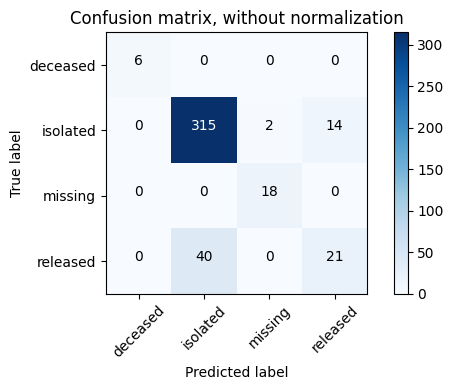

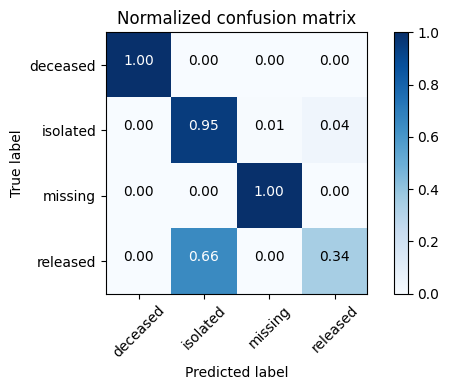

In [132]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_test_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(dpi = 100)
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
#plt.savefig('figures/RF_cm_multi_class.png')

# Plot normalized confusion matrix
plt.figure(dpi = 100)
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
#plt.savefig('figures/RF_cm_proportion_multi_class.png', bbox_inches="tight")
plt.show()

**Our model has a fairly good overall test accuracy of 86.5% and could classify `deceased`, `isolated` and `missing` state very well. But, it could not classify the `released` state well**. It has a very low recall score for the `released` state (only 34%). Recall though that this model has overfitting issue.

In [133]:
print(classification_report(y_test, y_test_pred, target_names = class_names))

              precision    recall  f1-score   support

    deceased       1.00      1.00      1.00         6
    isolated       0.89      0.95      0.92       331
     missing       0.90      1.00      0.95        18
    released       0.60      0.34      0.44        61

    accuracy                           0.87       416
   macro avg       0.85      0.82      0.83       416
weighted avg       0.85      0.87      0.85       416



### Plot feature importances
The random forest algorithm can be used as a regression or classification model. In either case it tends to be a bit of a black box, where understanding what's happening under the hood can be difficult. Plotting the feature importances is one way that you can gain a perspective on which features are driving the model predictions.

In [134]:
# feature_importance = clf.feature_importances_
feature_importance = rf_grid_cv.best_estimator_.feature_importances_
len(feature_importance)

181

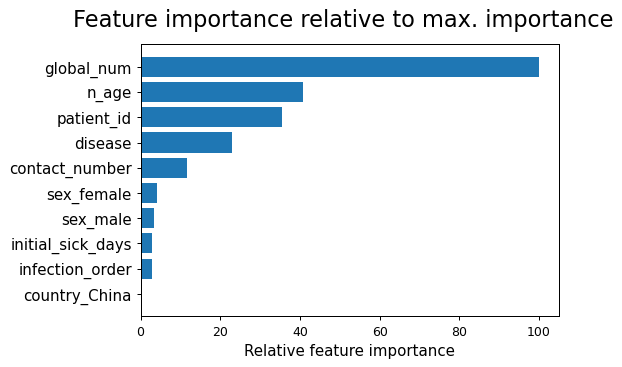

In [135]:
n_feature_importance = 10 # Plot for top 10 important features

# Make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())[:n_feature_importance]
sorted_idx = np.argsort(feature_importance)[:n_feature_importance]

pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(dpi = 90)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx], fontsize = 12)
plt.xlabel('Relative feature importance', fontsize = 12)
plt.suptitle('Feature importance relative to max. importance', fontsize = 18)
plt.show()

We can also print the numerical values of the relative feature importances.

In [136]:
# Print relative feature importances
imp = pd.Series(feature_importance[sorted_idx], index=X.columns[sorted_idx])
imp = imp.sort_values(ascending=False)
print(imp)

global_num           100.000000
n_age                 40.655144
patient_id            35.513051
disease               22.959339
contact_number        11.747807
sex_female             4.098108
sex_male               3.331691
initial_sick_days      2.896737
infection_order        2.858868
country_China          0.342295
dtype: float64


We will try another ML model, namely, support vector classification, to see if we can get better predictive performance.

### Support vector classification and Hyperparameter optimization

In [137]:
clf = SVC(kernel = 'linear', class_weight = 'balanced')

modelStandardScaler = StandardScaler()
modelStandardScaler.fit(X_train)

# GridSearchCV to tune number of trees
params = {'C': [10, 100]} # The strength of the regularization is 
                          # inversely proportional to C.
    
rf_grid_cv = GridSearchCV(clf, params)
rf_grid_cv.fit(modelStandardScaler.transform(X_train), y_train)

# Print best parameters and results
print(rf_grid_cv.best_params_)
print(rf_grid_cv.best_score_)

{'C': 100}
0.7435417345055899


In [138]:
# Train score
y_train_pred = rf_grid_cv.predict(modelStandardScaler.transform(X_train))
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Train set accuracy: {train_accuracy}")

Train set accuracy: 0.7904876580373269


In [139]:
# Test score
y_test_pred = rf_grid_cv.predict(modelStandardScaler.transform(X_test))
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test set accuracy: {test_accuracy}")

Test set accuracy: 0.7139423076923077


Confusion matrix, without normalization
[[  6   0   0   0]
 [  6 232   8  85]
 [  0   1  17   0]
 [  1  18   0  42]]
Normalized confusion matrix
[[1.   0.   0.   0.  ]
 [0.02 0.7  0.02 0.26]
 [0.   0.06 0.94 0.  ]
 [0.02 0.3  0.   0.69]]


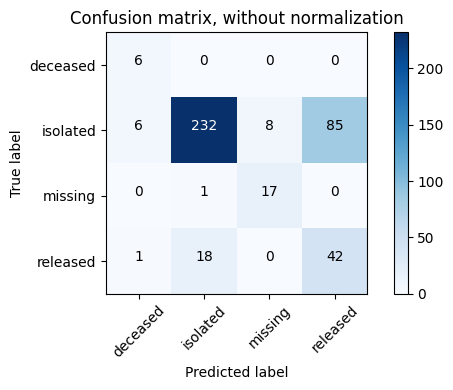

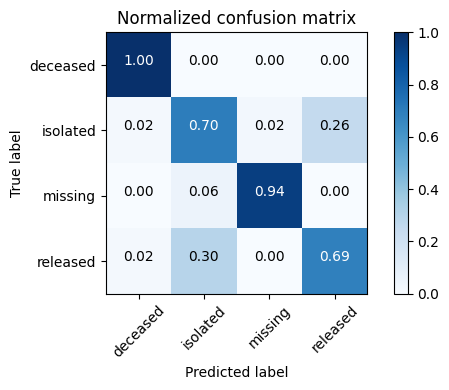

In [140]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_test_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(dpi = 100)
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
#plt.savefig('figures/RF_cm_multi_class.png')

# Plot normalized confusion matrix
plt.figure(dpi = 100)
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
#plt.savefig('figures/RF_cm_proportion_multi_class.png', bbox_inches="tight")
plt.show()

**This model shows better performance than the random forest classifier even though both the training accuracy (79.04%) and test accuracy (71.39%) reduced.** This model 
could classify `deceased` and `missing` states very well, while `isolated` and `released` states are classified reasonably well (not poor at all).

In [141]:
print(classification_report(y_test, y_test_pred, target_names = class_names))

              precision    recall  f1-score   support

    deceased       0.46      1.00      0.63         6
    isolated       0.92      0.70      0.80       331
     missing       0.68      0.94      0.79        18
    released       0.33      0.69      0.45        61

    accuracy                           0.71       416
   macro avg       0.60      0.83      0.67       416
weighted avg       0.82      0.71      0.74       416



# Conclusions

+ We did an **exhaustive Data Wrangling** to fill all of missing values using practical sense.

+ Two models (Random Forest Classifier and Support Vector Classifier) are built using `GridSearchCV`. Random forest model has overfitting issue, while the Support Vector Classifier model showed much better predictive performance.